In [1]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")
print(f"Devices: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Install necessary libraries
# We remove tensorflow because it is incompatible with your Python 3.14 version
%pip install pandas numpy scikit-learn nltk matplotlib seaborn

print("Installation Complete. Proceed to next cell.")

Note: you may need to restart the kernel to use updated packages.
Installation Complete. Proceed to next cell.


In [3]:
# Install necessary libraries if not already installed
!pip install pandas numpy scikit-learn nltk matplotlib seaborn tensorflow

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, 
                             roc_curve, auc, roc_auc_score)

print("Libraries Imported Successfully")

Libraries Imported Successfully


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/srirammuvva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srirammuvva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/srirammuvva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/srirammuvva/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Load the dataset (handling Latin encoding which is common for this dataset)
df = pd.read_csv("spam.csv", encoding='latin-1')

# Keep only necessary columns and rename them
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

# Map labels to numbers (Ham=0, Spam=1)
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})

# Display first 5 rows
print("Dataset Loaded:")
display(df.head())

# Check class distribution
print("\nClass Distribution:")
print(df['label'].value_counts())

Dataset Loaded:


,label,text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0



Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


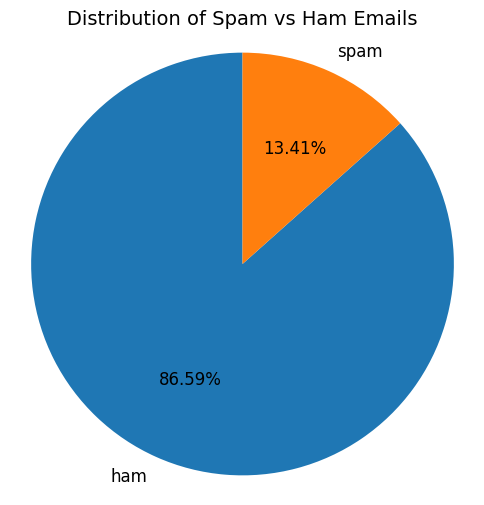

In [5]:
# --- PIE CHART VISUALIZATION ---
import matplotlib.pyplot as plt

# 1. Count the number of Spam and Ham emails
# 'label' is the column name we created in Cell 3
label_counts = df['label'].value_counts()

# 2. Define labels and sizes
labels = label_counts.index
sizes = label_counts.values

# 3. Create the Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, 
        labels=labels, 
        autopct='%1.2f%%',  # Shows percentage with 2 decimal places
        startangle=90,      # Rotates the start to 90 degrees
        colors=['#1f77b4', '#ff7f0e'], # Blue and Orange (standard colors)
        textprops={'fontsize': 12}) # Make text readable

plt.title('Distribution of Spam vs Ham Emails', fontsize=14)
plt.axis('equal') # Ensures pie is drawn as a circle

# 4. Show the plot
plt.show()

In [6]:
# Initialize Stemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove special characters, URLs, numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # 3. Tokenization
    tokens = nltk.word_tokenize(text)
    
    # 4. Remove Stopwords & Stemming
    clean_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return " ".join(clean_tokens)

# Apply preprocessing
print("Preprocessing data... (This might take a moment)")
df['clean_text'] = df['text'].apply(preprocess_text)
print("Preprocessing Complete.")
display(df[['text', 'clean_text']].head())

Preprocessing data... (This might take a moment)
Preprocessing Complete.


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


In [7]:
# Initialize TF-IDF Vectorizer
# Max features = 5000 (Uses only top 5000 common words to keep model fast)
tfidf = TfidfVectorizer(max_features=5000)

# Fit and Transform
X = tfidf.fit_transform(df['clean_text']).toarray() # Convert to array for Neural Network compatibility
y = df['label_enc'].values

print(f"Feature Matrix Shape: {X.shape}")

Feature Matrix Shape: (5572, 5000)


In [8]:
# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (4457, 5000)
Testing Data: (1115, 5000)


In [9]:
# 1. Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("Naive Bayes Trained.")

# 2. Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print("Logistic Regression Trained.")

# 3. Support Vector Machine (SVM) - Probability=True needed for ROC Curve
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
print("SVM Trained.")

Naive Bayes Trained.
Logistic Regression Trained.
SVM Trained.


In [10]:
# Define a Simple Neural Network
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(5000,)), # Input Layer
    Dropout(0.5),                                     # Dropout to prevent overfitting
    Dense(32, activation='relu'),                     # Hidden Layer
    Dense(1, activation='sigmoid')                    # Output Layer (Binary)
])

# Compile Model
model_nn.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train the Model (This produces the logs you see in your photo)
print("Starting Neural Network Training...")
history = model_nn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

/Users/srirammuvva/Documents/oibsip_taskno4/tf_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-30 12:10:11.308976: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-11-30 12:10:11.309025: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-11-30 12:10:11.309034: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
2025-11-30 12:10:11.309189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 12:10:11.309199: I tensorflow/core/common_runtime/pluggable_device/pluggable_de

Starting Neural Network Training...
Epoch 1/10


2025-11-30 12:10:11.806483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8860 - loss: 0.3282 - val_accuracy: 0.9641 - val_loss: 0.1192
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9753 - loss: 0.0753 - val_accuracy: 0.9821 - val_loss: 0.0681
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9890 - loss: 0.0386 - val_accuracy: 0.9839 - val_loss: 0.0672
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9928 - loss: 0.0233 - val_accuracy: 0.9848 - val_loss: 0.0671
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9948 - loss: 0.0155 - val_accuracy: 0.9848 - val_loss: 0.0678
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9980 - loss: 0.0099 - val_accuracy: 0.9839 - val_loss: 0.0792
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9982 - loss: 0.0078 - val_accuracy: 0.9839 - val_loss: 0.0848
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.9839 - val_

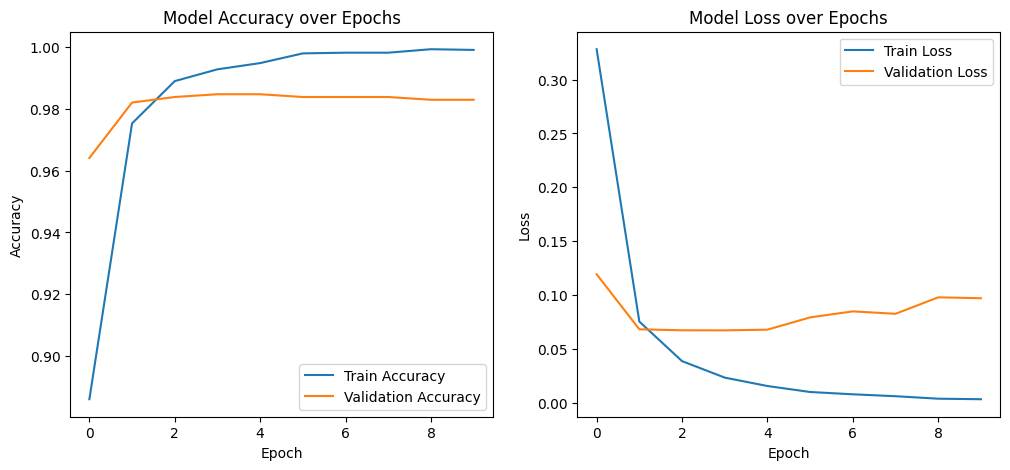

In [11]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


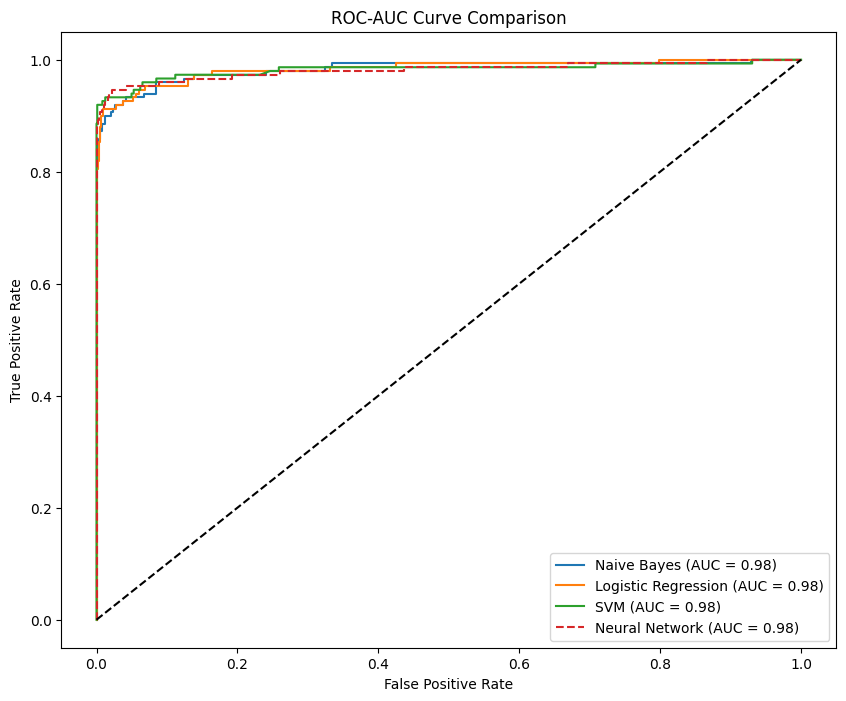

In [12]:
# Predictions (Probabilities)
y_prob_nb = nb_model.predict_proba(X_test)[:, 1]
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
y_prob_nn = model_nn.predict(X_test).ravel()

# Calculate ROC Curve metrics
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_score(y_test, y_prob_nb):.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_score(y_test, y_prob_svm):.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_score(y_test, y_prob_nn):.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison')
plt.legend()
plt.show()

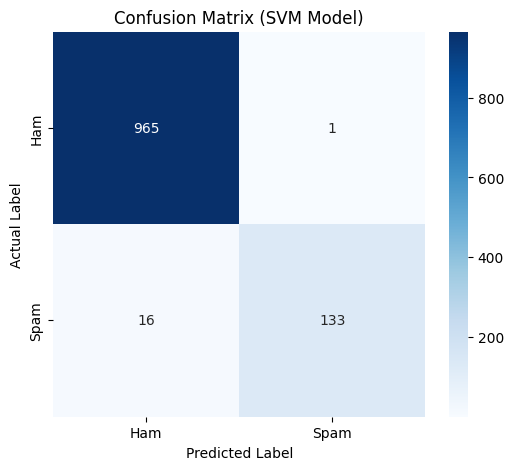

Classification Report (SVM):

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



In [13]:
# Let's evaluate the SVM model (usually the best ML model)
y_pred_svm = svm_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix (SVM Model)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("Classification Report (SVM):\n")
print(classification_report(y_test, y_pred_svm))

In [14]:
def predict_message(message):
    # Preprocess
    clean_msg = preprocess_text(message)
    # Vectorize
    vec_msg = tfidf.transform([clean_msg]).toarray()
    # Predict (Using Neural Network for probability)
    prob = model_nn.predict(vec_msg)[0][0]
    
    label = "SPAM" if prob > 0.5 else "HAM"
    print(f"Message: '{message}'")
    print(f"Prediction: {label} (Confidence: {prob:.2%})\n")

# Test Samples
predict_message("Congratulations! You've won a $1000 Walmart gift card. Click here.")
predict_message("Hey, are we still meeting for lunch tomorrow?")
predict_message("URGENT: Your account has been locked. Update details immediately.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Message: 'Congratulations! You've won a $1000 Walmart gift card. Click here.'
Prediction: HAM (Confidence: 1.31%)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Message: 'Hey, are we still meeting for lunch tomorrow?'
Prediction: HAM (Confidence: 0.00%)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Message: 'URGENT: Your account has been locked. Update details immediately.'
Prediction: SPAM (Confidence: 82.71%)



In [15]:
# Save SVM model and Vectorizer
pickle.dump(svm_model, open("spam_model.pkl", "wb"))
pickle.dump(tfidf, open("vectorizer.pkl", "wb"))

# Save Keras Model (if you want to use the Neural Network later)
model_nn.save("spam_nn_model.h5")

print("Models saved successfully.")

Models saved successfully.
